# Predicting Patient Readmission with a Hybrid Deep Learning Model

### Project Objective
This notebook develops and optimizes a deep learning model to predict the likelihood of a patient being readmitted to a hospital. The goal is to create a robust, high-performing model by leveraging a hybrid architecture and systematic hyperparameter tuning.

### Methodology
The core of this solution is a hybrid neural network that processes different types of features using specialized layers:
*   **1D Convolutional Neural Network (CNN):** Used to extract spatial patterns from the numerical and one-hot encoded categorical features.
*   **Entity Embeddings:** Used to create dense, meaningful vector representations of high-cardinality categorical features, capturing complex relationships between their categories.
*   **Robust Evaluation:** The model is trained using a rigorous process that prevents overfitting by identifying the optimal training duration and is evaluated on a completely unseen test set to provide a reliable measure of its real-world performance.

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding, concatenate, Reshape, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import optuna

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [29]:
# List physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU(s) detected!")
    for gpu in gpus:
        print(f" - {gpu}")
    print("TensorFlow will use the GPU by default when available.")
else:
    print("⚠️ No GPU detected. Using CPU only.")

🚀 GPU(s) detected!
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow will use the GPU by default when available.


In [30]:
# Load the preprocessed data
# The data was preprocessed in the data_preprocessing.ipynb notebook
try:
    data = pd.read_csv('../../dataPreprocessing/medical_data.csv')
except FileNotFoundError:
    data = pd.read_pickle('../../dataPreprocessing/medical_data.pkl')

# These columns are derived from the target variable ('readmitted') and must be removed.
leaky_features = ['mb_readmitted_lt30_ct', 'mb_readmitted_gt30_ct', 'mb_readmitted_no_ct', 'readmitted_ind']
data.drop(columns=[col for col in leaky_features if col in data.columns], inplace=True, errors='ignore')

pd.set_option('display.max_columns', None)
print("Data shape:", data.shape)
print("Data head:")
data.head()

/tmp/ipykernel_726/1422035621.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../dataPreprocessing/medical_data.csv')


Data shape: (78049, 202)
Data head:


,encounter_id,patient_nbr,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,admission_type,discharge_disposition,admission_source,mb_admission_grp_1_ct,mb_admission_grp_2_ct,mb_discharge_grp_1_ct,mb_discharge_grp_2_ct,mb_admission_type_ct,distinct_diag_count,diagnosis_1,diagnosis_2,diagnosis_3,diag_1_freq,diag_2_freq,diag_3_freq,LTIS_38_ind,LTIS_40_ind,LTIS_36_ind,LTIS_320_ind,LTIS_324_ind,CE_410_ind,CE_430_ind,CE_431_ind,CE_415_ind,CE_428_ind,CMN_155_ind,CMN_162_ind,CMN_191_ind,CMN_197_ind,CMN_199_ind,OF_570_ind,OF_584_ind,OF_585_ind,OF_277_ind,NBD_331_ind,NBD_340_ind,NBD_780_ind,NBD_852_ind,STI_806_ind,STI_861_ind,STI_864_ind,STI_958_ind,OCC_250_ind,OCC_995_ind,OCC_986_ind,OCC_989_ind,diagnosis_combo_frequency,sorted_diag_1,sorted_diag_2,sorted_diag_3,sorted_diag_1_frequency,sorted_diag_2_frequency,sorted_diag_3_frequency,diagnosis_combo_string,is_high_risk_combo,dx_428_ind_max,dx_428_ind_sum,dx_403_ind_max,dx_403_ind_sum,dx_707_ind_max,dx_707_ind_sum,dx_585_ind_max,dx_585_ind_sum,dx_491_ind_max,dx_491_ind_sum,dx_396_ind_max,dx_396_ind_sum,dx_440_ind_max,dx_440_ind_sum,dx_453_ind_max,dx_453_ind_sum,dx_571_ind_max,dx_571_ind_sum,dx_284_ind_max,dx_284_ind_sum,dx_304_ind_max,dx_304_ind_sum,dx_482_ind_max,dx_482_ind_sum,dx_150_ind_max,dx_150_ind_sum,dx_282_ind_max,dx_282_ind_sum,dx_332_ind_max,dx_332_ind_sum,dx_443_ind_max,dx_443_ind_sum,dx_719_ind_max,dx_719_ind_sum,dx_423_ind_max,dx_423_ind_sum,dx_281_ind_max,dx_281_ind_sum,dx_536_ind_max,dx_536_ind_sum,dx_368_ind_max,dx_368_ind_sum,dx_515_ind_max,dx_515_ind_sum,dx_595_ind_max,dx_595_ind_sum,dx_572_ind_max,dx_572_ind_sum,dx_681_ind_max,dx_681_ind_sum,dx_581_ind_max,dx_581_ind_sum,dx_537_ind_max,dx_537_ind_sum,dx_490_ind_max,dx_490_ind_sum,dx_583_ind_max,dx_583_ind_sum,dx_V46_ind_max,dx_V46_ind_sum,dx_519_ind_max,dx_519_ind_sum,dx_300_ind_max,dx_300_ind_sum,dx_567_ind_max,dx_567_ind_sum,dx_E92_ind_max,dx_E92_ind_sum,dx_V49_ind_max,dx_V49_ind_sum,dx_094_ind_max,dx_094_ind_sum,dx_514_ind_max,dx_514_ind_sum,dx_494_ind_max,dx_494_ind_sum,dx_042_ind_max,dx_042_ind_sum,dx_404_ind_max,dx_404_ind_sum,dx_346_ind_max,dx_346_ind_sum,dx_792_ind_max,dx_792_ind_sum,dx_398_ind_max,dx_398_ind_sum,dx_753_ind_max,dx_753_ind_sum,dx_577_ind_max,dx_577_ind_sum,dx_730_ind_max,dx_730_ind_sum,dx_444_ind_max,dx_444_ind_sum,dx_459_ind_max,dx_459_ind_sum,dx_790_ind_max,dx_790_ind_sum,dx_337_ind_max,dx_337_ind_sum,dx_397_ind_max,dx_397_ind_sum,dx_292_ind_max,dx_292_ind_sum,dx_V42_ind_max,dx_V42_ind_sum,dx_289_ind_max,dx_289_ind_sum,alcohol_history_ind,obesity_history_ind,mh_history_ind,encounter_ct,mb_time_in_hospital,mb_num_lab_procedures_ct,mb_num_procedures_ct,mb_num_medications_ct,mb_number_outpatient_ct,mb_number_emergency_ct,mb_number_inpatient_ct,mb_number_diagnoses_ct,age_encoded,dummy
0,64410,86047875,Female,2,11,5,13,2,0,1,648,250,V27,6,NaN,No,No,Steady,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,1,0,1,0,0,3,DIABETES IN PREG-UNSPEC,DIABETES MELLITUS,DELIVER-SINGLE LIVEBORN,285,12794,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,DIABETES MELLITUS,DIABETES IN PREG-UNSPEC,DELIVER-SINGLE LIVEBORN,36015,417,37,(250 648 V27),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,11,5,13,2,0,1,6,1.0,1
1,500364,82442376,Male,2,44,1,16,0,0,0,8,250,403,7,NaN,No,No,No,No,No,No,Up,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,1,0,1,0,0,3,INTEST INFEC E COLI NOS,DIABETES MELLITUS,MAL HY KID W CR KID I-IV,515,12794,2357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,DIABETES MELLITUS,MAL HY KID W CR KID I-IV,INTEST INFEC E COLI NOS,36015,2261,83

## Data Preparation and Preprocessing Strategy

A critical prerequisite for building an effective deep learning model is a robust and well-defined data preprocessing pipeline. Our strategy is designed to handle the mixed data types present in the dataset (numerical, low-cardinality categorical, and high-cardinality categorical) and prepare them for their respective model branches.

The process involves the following key steps:

1.  **Feature and Target Definition**: We first define our target variable, `readmitted_binary`, and isolate the features that will be used for prediction.
2.  **Feature Segregation**: We programmatically separate the features into three distinct groups based on their data type and cardinality (the number of unique values).
3.  **Train-Test Split**: The data is split into training and testing sets *before* any transformations are fitted. This is a crucial step to prevent data leakage and ensure our final evaluation is unbiased.
4.  **Unified Preprocessing Pipeline**: We use Scikit-learn's `ColumnTransformer` to apply the correct transformation to each feature group in a single, unified step:
    *   **Numerical Features**: These are scaled using `StandardScaler` to normalize their range, which helps the model converge more efficiently.
    *   **Low-Cardinality Categorical Features**: These are transformed using `OneHotEncoder`, creating a binary column for each category. This is suitable for features with a small number of unique values.
    -   **High-Cardinality Categorical Features**: These are converted into unique integers using `OrdinalEncoder`. This is not for establishing order, but as a necessary step to prepare these features for the subsequent `Embedding` layers in our neural network, which will learn a meaningful vector representation for each integer.

In [31]:
# The target variable is 'readmitted'. We'll convert this into a binary classification problem:
# 1 if readmitted (value is '<30' or '>30'), 0 otherwise (value is 'NO').
if 'readmitted' in data.columns:
    data['readmitted_binary'] = data['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)
    target = 'readmitted_binary'
    
    # Drop original readmitted columns and patient_nbr as it's an identifier
    features = data.drop(columns=[target, 'readmitted', 'patient_nbr'], errors='ignore')
    y = data[target]
    X = features
    
    print("Target variable created.")
    print(y.value_counts())
else:
    print("Target column 'readmitted' not found. Please define the target variable.")
    # As a placeholder:
    X, y = None, None


Target variable created.
readmitted_binary
0    42307
1    35742
Name: count, dtype: int64


In [32]:
if X is not None:
    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    # Define a threshold for high cardinality
    CARDINALITY_THRESHOLD = 50
    
    # Separate categorical features into low and high cardinality
    high_cardinality_features = [col for col in categorical_features if X[col].nunique() > CARDINALITY_THRESHOLD]
    low_cardinality_features = [col for col in categorical_features if X[col].nunique() <= CARDINALITY_THRESHOLD]

    print(f"Numerical features: {len(numerical_features)}")
    print(f"Low-cardinality categorical features (to be one-hot encoded): {len(low_cardinality_features)}")
    print(f"High-cardinality categorical features (to be embedded): {len(high_cardinality_features)}")
    print(f" -> High-cardinality features: {high_cardinality_features}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nData split into training and testing sets.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

Numerical features: 176
Low-cardinality categorical features (to be one-hot encoded): 14
High-cardinality categorical features (to be embedded): 10
 -> High-cardinality features: ['diag_1', 'diag_2', 'diag_3', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'sorted_diag_1', 'sorted_diag_2', 'sorted_diag_3', 'diagnosis_combo_string']

Data split into training and testing sets.
X_train shape: (62439, 200)
X_test shape: (15610, 200)


In [33]:
if X is not None:
    # Ensure all categorical columns are strings to avoid mixed-type errors
    for col in low_cardinality_features + high_cardinality_features:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype(str)
            X_test[col] = X_test[col].astype(str)

    # Create transformers for each feature type
    numeric_transformer = StandardScaler()
    low_card_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    high_card_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    # Create a single preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat_low', low_card_transformer, low_cardinality_features),
            ('cat_high', high_card_transformer, high_cardinality_features)
        ],
        remainder='passthrough'
    )

    # Apply the preprocessing
    # The preprocessor is FIT ONLY on the training data
    X_train_processed = preprocessor.fit_transform(X_train)
    # It is then used to TRANSFORM both the training and test data
    X_test_processed = preprocessor.transform(X_test)

    print("Preprocessing complete.")
    print("Processed training data shape:", X_train_processed.shape)
    print("Processed testing data shape:", X_test_processed.shape)

Preprocessing complete.
Processed training data shape: (62439, 268)
Processed testing data shape: (15610, 268)


## Model Architecture and Design

To effectively handle the diverse types of data in our dataset, we have designed a hybrid neural network using the Keras Functional API. This flexible approach allows us to create a multi-branch model where different kinds of features are processed by specialized layers best suited for their nature. The outputs of these branches are then merged to make a final, unified prediction.

The model consists of the following key components:

### 1. Unified Input Layer
A single `Input` layer serves as the entry point for the entire preprocessed feature vector. This vector contains the scaled numerical features, the one-hot encoded low-cardinality features, and the integer-encoded high-cardinality features, all concatenated together.

### 2. Branch 1: CNN for Numerical and Low-Cardinality Features
This branch is designed to process the continuous numerical data and the one-hot encoded categorical data. It uses a 1D Convolutional Neural Network (CNN) to learn spatial hierarchies and patterns within this feature set.
*   **Slicing (`Lambda`):** A `Lambda` layer first slices the main input tensor to isolate only the numerical and one-hot encoded columns.
*   **Reshaping:** The sliced data is reshaped into a 3D tensor, which is the required input format for a `Conv1D` layer.
*   **Convolution (`Conv1D`):** A 1D convolutional layer scans the features to identify local patterns.
*   **Pooling (`MaxPooling1D`):** A max-pooling layer downsamples the output, making the learned patterns more robust.
*   **Flattening:** The pooled feature map is flattened into a 1D vector to be passed to the final classification layers.

### 3. Branch 2: Embeddings for High-Cardinality Features
This branch is dedicated to handling the high-cardinality categorical features, which are not suitable for one-hot encoding.
*   **Slicing (`Lambda`):** For each high-cardinality feature, a `Lambda` layer slices the main input tensor to extract its specific integer-encoded value.
*   **Embedding (`Embedding`):** An `Embedding` layer converts each integer into a dense, low-dimensional vector. This layer learns a meaningful representation for each category, capturing semantic relationships between them in a way that one-hot encoding cannot.
*   **Flattening:** The resulting embedding vectors are flattened to prepare them for merging.

### 4. Merging and Final Classification
*   **Concatenation:** The output vector from the CNN branch is concatenated with the output vectors from all the embedding branches, creating a single, comprehensive feature vector.
*   **Classification Head:** This final, fully-connected part of the network makes the prediction:
    *   A `Dense` layer with a `relu` activation function learns complex, non-linear combinations of the merged features.
    *   A `Dropout` layer is applied for regularization to prevent overfitting.
    *   The final `Dense` output layer consists of a single neuron with a `sigmoid` activation function, which outputs a probability score between 0 and 1 for the binary classification task (readmitted or not).

In [34]:
if 'X_train_processed' in locals():
    # --- Get information from the preprocessor ---
    # Get the number of one-hot encoded features
    num_ohe_features = preprocessor.named_transformers_['cat_low'].get_feature_names_out().shape[0]
    
    # Define start and end indices for each data type in the processed array
    num_start_idx = 0
    ohe_start_idx = len(numerical_features)
    embed_start_idx = ohe_start_idx + num_ohe_features
    
    # --- Define Model Inputs ---
    # A single input layer that takes the entire processed feature vector
    input_layer = Input(shape=(X_train_processed.shape[1],), name='main_input')

    # --- Branch 1: Numerical and One-Hot Encoded Features for CNN ---
    # Slice the input to get the numerical and OHE data
    cnn_input_data = Lambda(lambda x: x[:, num_start_idx:embed_start_idx], name='cnn_data_slicer')(input_layer)
    # Reshape it for the Conv1D layer
    reshaped_cnn_data = Reshape((embed_start_idx, 1), name='reshape_for_cnn')(cnn_input_data)
    
    # CNN layers
    conv1d = Conv1D(filters=32, kernel_size=3, activation='relu', name='conv1d_layer')(reshaped_cnn_data)
    pool1d = MaxPooling1D(pool_size=2, name='maxpool1d_layer')(conv1d)
    flatten_cnn = Flatten(name='flatten_cnn')(pool1d)

    # --- Branch 2: High-Cardinality Features for Embedding ---
    embedding_layers = []
    for i, col_name in enumerate(high_cardinality_features):
        # Slice the input to get the integer-encoded category for this feature
        category_input = Lambda(lambda x: x[:, embed_start_idx + i], name=f'slice_{col_name}')(input_layer)
        
        # Get the number of unique categories for this feature from the fitted OrdinalEncoder
        vocab_size = len(preprocessor.named_transformers_['cat_high'].categories_[i])
        embedding_dim = 10 # Hyperparameter: size of the embedding vector
        
        # Create the embedding layer
        embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name=f'embed_{col_name}')(category_input)
        flatten_embed = Flatten(name=f'flatten_embed_{col_name}')(embedding)
        embedding_layers.append(flatten_embed)

    # --- Merge Branches ---
    # Combine the output of the CNN branch with all the embedding branches
    merged = concatenate([flatten_cnn] + embedding_layers, name='concatenate_branches')

    # --- Final Classification Layers ---
    dense1 = Dense(64, activation='relu', name='dense_1')(merged)
    dropout1 = Dropout(0.5, name='dropout_1')(dense1)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(dropout1)

    # --- Create and Compile the Model ---
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 268)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_data_slicer     │ (None, 258)       │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_for_cnn     │ (None, 258, 1)    │          0 │ cnn_data_slicer[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_layer        │ (None, 256, 32)   │        128 │ reshape_for_cnn[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_diag_1        │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_diag_2        │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_diag_3        │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_diagnosis_1   │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_diagnosis_2   │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_diagnosis_3   │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_sorted_diag_1 │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_sorted_diag_2 │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_sorted_diag_3 │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_diagnosis_co… │ (None)            │          0 │ main_input[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_layer     │ (None, 128, 32)   │          0 │ conv1d_layer[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_diag_1        │ (None, 10)        │      6,510 │ slice_diag_1[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_diag_2        │ (None, 10)        │      6,290 │ slice_diag_2[0][

 Total params: 600,911 (2.29 MB)

 Trainable params: 600,911 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
if 'model' in locals():
    # Define the EarlyStopping callback
    # It will monitor the validation loss and stop training when it hasn't improved for 3 epochs.
    # restore_best_weights=True ensures the model's weights are reset to the best epoch.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_processed, y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping]  # Add the callback here
    )
    print("Model training complete.")

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7390 - loss: 0.5416 - val_accuracy: 0.7751 - val_loss: 0.4780
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7776 - loss: 0.4803 - val_accuracy: 0.7866 - val_loss: 0.4695
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8083 - loss: 0.4241 - val_accuracy: 0.7646 - val_loss: 0.5190
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8583 - loss: 0.3348 - val_accuracy: 0.7516 - val_loss: 0.5784
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8816 - loss: 0.2817 - val_accuracy: 0.7461 - val_loss: 0.6193
Model training complete.


Test Loss: 0.4735
Test Accuracy: 0.7824


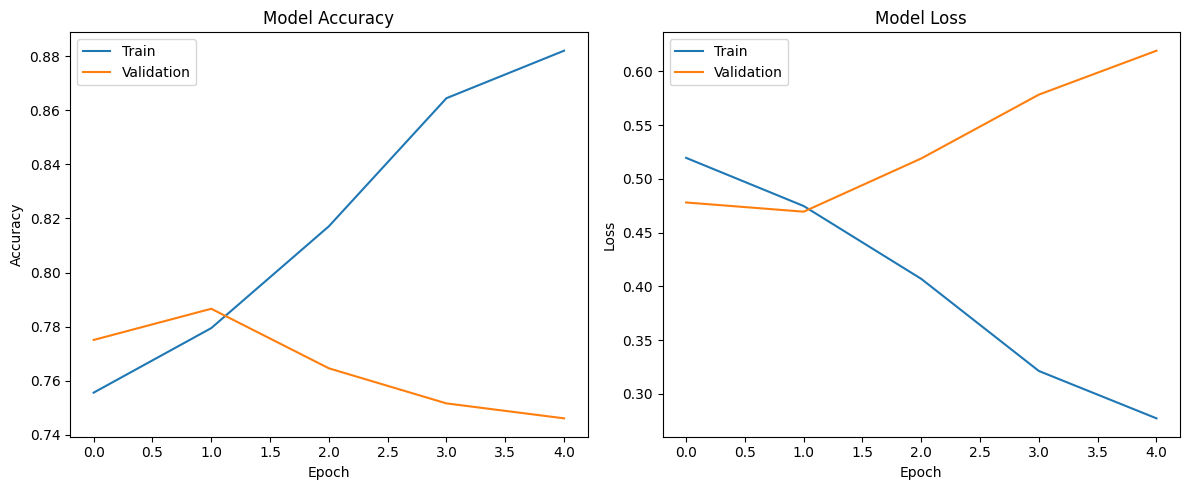

In [36]:
if 'model' in locals():
    loss, accuracy = model.evaluate(X_test_processed, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

import matplotlib.pyplot as plt

if 'history' in locals():
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()